# Visualización de imágenes astronómicas

Vamos a implementar Astropy para una de sus funcionas más impleadas: la visualización de imágenes astronómicas. Para ello, vamos a tomar como ejemplo el caso de Cassiopeia A, una remanente de supernova que se estima explotó hace ~350 años.

Aquí conoceremos el uso de los archivos FITS (Flexible Image Transport System), el cual es el modo de manejo de datos astronómicos más usado. La información usada en este Notebook corresponde al telescopio espacial Chandra, el cual observa en el ultravioleta, que es la luz caliente presente en el objeto.

![chandra](https://images.firstpost.com/wp-content/uploads/2018/10/Chandra-x-ray-1280.jpg?im=FitAndFill=(596,336))

## Abrir un archivo FITS

De esto se encarga astropy en su funcionalidad "fits". Para esto abriremos solo la primera imagen con nombre ``casa_0.5-1.5deV.fits.gz``, luego nos encargaremos de las demás.

In [27]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



In [28]:
image0 =fits.open('casa_0.5-1.5keV.fits.gz')



Un archivo "fits" guarda información importante sobre el objeto astronómico que ha sido observado, tanto la imagen capturada por la cámara como los metadatos (información adicional sobre la imagen contenida).

In [29]:
image0.info()

Filename: casa_0.5-1.5keV.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (1024, 1024)   float32   


Vemos que solo contiene información primaria (PRIMARY), el cual contiene la imagen y un encabezado (header) de 26 renglones. Aquí el término HDU significa "Header Data Unit". Vamos a explorarlo:

In [30]:
image_hdu=image0['PRIMARY']

Vamos a explorar los datos de la imagen, para eso usamos la opción ``.data``


In [31]:
data_image=image_hdu.data

Este contiene una matriz en 2 dimensiones. Para graficarlo, usamos la opción `plt.imshow()` para visualizarlo:

### Imagen de la primera banda de menor intensidad

Cada pixel tiene un brillo dado por la cantidad de fotonos que este registra. Sin emvbargo al ser tan bajo el brillo en escala lineal se ven de muy bajo brillo. Para tener mejor visibilidad se debe pasar a escala logarítmica.

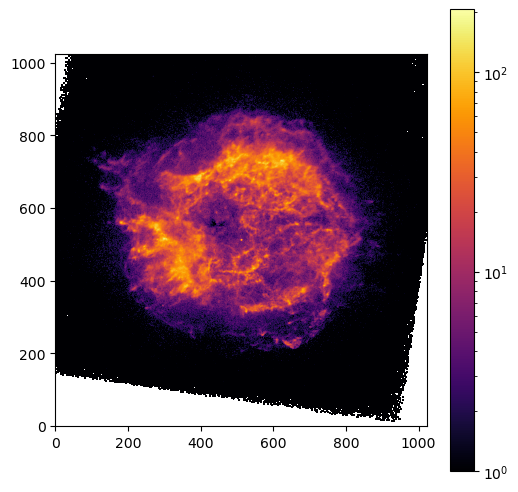

In [32]:
plt.figure(figsize=(6,6))
#origin=lower-> el pixel (0,0) es el que está en la parte inferior izquierda
plt.imshow(data_image, origin="lower",cmap="inferno", norm=LogNorm())

plt.colorbar()

Para ver los medatados, usamos la opción `.header` attribute:

info dada por el autor de la imagen

In [33]:
image_hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis Length                                    
NAXIS2  =                 1024 / Axis Length                                    
OBJECT  = 'Cassiopeia A'                                                        
DATE-OBS= '2007-12-05T22:01:59'                                                 
DATE-END= '2007-12-08T20:07:24'                                                 
LTM1_1  =                    1                                                  
LTM1_2  =                    0                                                  
LTM2_1  =                    0                                                  
LTM2_2  =                    1                                                  
LTV1    =                -36

Noten que los ejes corresponden a los pixeles (la cuadrícula impuesta por el tamaño del sensor en la cámara usada), lo correcto como buenos astrónomos es transformarlo en coordenadas del cielo a través del "World Coordinate System" (WCS). [astropy.wcs.WCS](http://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS).

La librería ``wcs`` de astropy se encarga tanto de convertir de pixeles a coordenadas celestes como de coordenadas celestes a pixeles según se necesite.

In [34]:
from astropy.wcs import WCS
#Para convertir de pixeles a coordenadas o de coordenadaas a pixeles

In [35]:
wcs_image=WCS(image_hdu.header)

#guarda la info que le permitirá hacer esa conversión

Usando otros métodos como SkyCoord podríamos saber, por ejemplo, qué posición del cielo corresponde cada pixel.

In [36]:
from astropy.coordinates import SkyCoord

position_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')
position_casa.to_pixel(wcs_image)

#da el pixel en el que se ubican las coordenadas de casA
# convierte coordenadas a pixeles

(array(511.59886806), array(511.29670003))

Para hacer los cambios en nuestro ejercicio, usamos el cambio de proyección `projection=wcs` en el `plt.subplot()`:

In [37]:
plt.figure(figsize=(6,6))
ax=plt.subplot(projection=wcs_image) #para mostrar en formato de coordenadas
ax.imshow(data_image, origin="lower",cmap="inferno")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

TypeError: WCSAxes.__init__() got multiple values for argument 'wcs'

<Figure size 600x600 with 0 Axes>

Podemos agregar un grid a la figura a través de `ax.grid()`:

Qué tal si agregamos una estrella de referencia para marcar una posición específica de la figura, digamos, la posición en donde ocurrió la explosión de `'Cas A'`:

In [ ]:
ra =
dec =

pix_ra =
pix_dec =



## Combinación de imágenes

Ahora, vamos a realizar una combinación de imágenes RGB, es decir, a cada sensor del telescopio Chandra le asignaremos un color falso para combinarse y observar detalles de la estructura física de ``Cas A``.

Para este proceso, tenemos que renormalizar los datos de cada banda de energía (sensor) con respecto a su valor máximo para luego combinarlo en un arreglo 3D que finalmente se graficará.

Primero, vamos a cargar los tres archivos al tiempo en un arreglo:

In [20]:
from astropy.visualization import AsinhStretch, LogStretch, SqrtStretch, LinearStretch



In [21]:
files=["casa_0.5-1.5keV.fits.gz","casa_1.5-3.0keV.fits.gz","casa_4.0-6.0keV.fits.gz"]

Con la función ``astropy.visualization`` simplemente se puede reajustar la escala de colores para no depender de los valores lineales del sensor y ver más detalles. Aquí usaremos la función Seno-Hiperbólico y Logarítmico.

## Visualizar la imagen compuesta

In [22]:
stretch = LogStretch(a=100)
data_rgb=[]

for file in files:
    image_hdu=fits.open(file)["PRIMARY"]
    data=image_hdu.data
    data=data/np.nanmax(data) #maximo valor ignorando los nan
    data=stretch(data)
    data_rgb.append(data)

In [23]:
data_stack=np.stack(data_rgb,axis=2)

In [24]:
plt.figure(figsize=(6.,6.))
ax=plt.subplot(projection=wcs_image)
ax.imshow(data_stack,origin="lower",cmap="inferno")
ax.grid(color="white",linewidth=0.3)


TypeError: WCSAxes.__init__() got multiple values for argument 'wcs'

<Figure size 600x600 with 0 Axes>

## Ejercicio:

Ya con lo anterior, tienen una herramienta básica para visualizar imágenes astronómicas en formato FITS. ¿Qué tal si hacen lo mismo con otras imágenes contenidas en internet?

Para ello, vamos a cambiar de banda y nos moveremos al infrarrojo. Entramos al portal del IRSA (InfraRed Science Archive), el cual contiene un compendio completo de información tomada por telescopios terrestres y espaciales en esta banda.

Entramos a la página: https://irsa.ipac.caltech.edu/frontpage/ y descargaremos tres imágenes de la galaxia M51 (el remolino) tomada por el telescopio espacial Spitzer. Por favor, para buscar las imágenes, seguir las instrucciones de su astrónomo de confianza ;)

In [38]:
files=["imC23.fits","imC22.fits","imC21.fits"]

In [39]:
stretch = LogStretch(a=100)
data_rgb=[]

for file in files:
    image_hdu=fits.open(file)["PRIMARY"]
    data=image_hdu.data
    data=data/np.nanmax(data) #maximo valor ignorando los nan
    data=stretch(data)
    data_rgb.append(data)

In [40]:
data_stack=np.stack(data_rgb,axis=2)

In [41]:
plt.figure(figsize=(6.,6.))
ax=plt.subplot(projection=wcs_image)
ax.imshow(data_stack,origin="lower",cmap="inferno")
ax.grid(color="white",linewidth=0.3)


TypeError: WCSAxes.__init__() got multiple values for argument 'wcs'

<Figure size 600x600 with 0 Axes>